### E-Commerce Customer Purchase Prediction
#### Phase 3: Model Training & Evaluation

Training and comparing multiple models to predict customer purchases

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import time
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Create directories
os.makedirs('results', exist_ok=True)
os.makedirs('images/models', exist_ok=True)

Step 1: Load Processed Data

In [52]:
print('Loading processed data from Phase 1...')

drop_features = [
    'days_active',          # r=1.00 with session_duration_minutes
    'views',                # r=0.99 with total_events
    'views_per_session',    # r=0.99 with events_per_session
    'views_per_day',        # r=0.99 with events_per_day
    'session_efficiency'    # r=0.95 with events_per_minute
]

X_train = pd.read_csv('data/phase_1/x_train.csv', index_col=0).drop(drop_features, axis=1)
X_test = pd.read_csv('data/phase_1/x_test.csv', index_col=0).drop(drop_features, axis=1)
y_train = pd.read_csv('data/phase_1/y_train.csv', index_col=0).squeeze()
y_test = pd.read_csv('data/phase_1/y_test.csv', index_col=0).squeeze()

print(f'Loaded training data: {X_train.shape}')
print(f'Loaded test data: {X_test.shape}')
print(f'Training conversion rate: {y_train.mean()*100:.2f}%')
print(f'Test conversion rate: {y_test.mean()*100:.2f}%')

Loading processed data from Phase 1...
Loaded training data: (497588, 31)
Loaded test data: (577996, 31)
Training conversion rate: 2.01%
Test conversion rate: 2.53%


Step 2: Feature Scaling

In [53]:
# scaler = StandardScaler()
scaler = RobustScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

print(f'Features scaled: {X_train_scaled.shape[1]}')

Features scaled: 31


Evaluation Function

In [54]:
def evaluate_model(name, model, X_test, y_test, training_time):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    accuracy = (y_pred == y_test).mean()
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    avg_precision = average_precision_score(y_test, y_pred_proba)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    results = {
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'PR-AUC': avg_precision,
        'Specificity': specificity,
        'True Positives': tp,
        'False Positives': fp,
        'False Negatives': fn,
        'Training Time (s)': training_time,
    }
    
    print(f'\n{name.upper()} RESULTS:')
    print(f'  Accuracy:    {accuracy:.4f}')
    print(f'  Precision:   {precision:.4f}')
    print(f'  Recall:      {recall:.4f}')
    print(f'  F1-Score:    {f1:.4f}')
    print(f'  ROC-AUC:     {roc_auc:.4f}')
    print(f'  PR-AUC:      {avg_precision:.4f}')
    print(f'  Specificity: {specificity:.4f}')
    print(f'\n  Confusion Matrix:')
    print(f'    TP: {tp:>8,}  FP: {fp:>8,}')
    print(f'    FN: {fn:>8,}')
    print(f'  Time: {training_time:.2f}s\n')
    
    return results

Step 3: Baseline Models (No Imbalance Handling)

Note: This step takes around ~10 minutes to run.

In [55]:
baseline_results = []

# Logistic Regression
print('Training Logistic Regression (Baseline)...')
start = time.time()
lr_model = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
lr_model.fit(X_train_scaled, y_train)
lr_time = time.time() - start
baseline_results.append(evaluate_model('Logistic Regression (Baseline)', lr_model, X_test_scaled, y_test, lr_time))

# Decision Tree
print('Training Decision Tree (Baseline)...')
start = time.time()
dt_model = DecisionTreeClassifier(max_depth=10, random_state=42)
dt_model.fit(X_train_scaled, y_train)
dt_time = time.time() - start
baseline_results.append(evaluate_model('Decision Tree (Baseline)', dt_model, X_test_scaled, y_test, dt_time))

# Random Forest
print('Training Random Forest (Baseline)...')
start = time.time()
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)
rf_time = time.time() - start
baseline_results.append(evaluate_model('Random Forest (Baseline)', rf_model, X_test_scaled, y_test, rf_time))

# Gradient Boosting
print('Training Gradient Boosting (Baseline)...')
start = time.time()
gb_model = GradientBoostingClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
gb_model.fit(X_train_scaled, y_train)
gb_time = time.time() - start
baseline_results.append(evaluate_model('Gradient Boosting (Baseline)', gb_model, X_test_scaled, y_test, gb_time))

baseline_df = pd.DataFrame(baseline_results)
display(baseline_df)

Training Logistic Regression (Baseline)...

LOGISTIC REGRESSION (BASELINE) RESULTS:
  Accuracy:    0.9734
  Precision:   0.3089
  Recall:      0.0402
  F1-Score:    0.0711
  ROC-AUC:     0.7616
  PR-AUC:      0.1122
  Specificity: 0.9977

  Confusion Matrix:
    TP:      589  FP:    1,318
    FN:   14,063
  Time: 3.57s

Training Decision Tree (Baseline)...

DECISION TREE (BASELINE) RESULTS:
  Accuracy:    0.9712
  Precision:   0.2361
  Recall:      0.0612
  F1-Score:    0.0971
  ROC-AUC:     0.7449
  PR-AUC:      0.0941
  Specificity: 0.9949

  Confusion Matrix:
    TP:      896  FP:    2,899
    FN:   13,756
  Time: 3.48s

Training Random Forest (Baseline)...

RANDOM FOREST (BASELINE) RESULTS:
  Accuracy:    0.9749
  Precision:   0.6559
  Recall:      0.0179
  F1-Score:    0.0349
  ROC-AUC:     0.7786
  PR-AUC:      0.1426
  Specificity: 0.9998

  Confusion Matrix:
    TP:      263  FP:      138
    FN:   14,389
  Time: 4.37s

Training Gradient Boosting (Baseline)...

GRADIENT BOOSTIN

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC,PR-AUC,Specificity,True Positives,False Positives,False Negatives,Training Time (s)
0,Logistic Regression (Baseline),0.973389,0.308862,0.040199,0.071140,0.761606,0.112246,0.997660,589,1318,14063,3.568012
1,Decision Tree (Baseline),0.971185,0.236100,0.061152,0.097143,0.744859,0.094101,0.994854,896,2899,13756,3.478492
2,Random Forest (Baseline),0.974867,0.655860,0.017950,0.034943,0.778556,0.142624,0.999755,263,138,14389,4.368252
3,Gradient Boosting (Baseline),0.973784,0.371867,0.049618,0.087553,0.781655,0.129802,0.997820,727,1228,13925,184.503922


Step 4: Class Imbalance Handling with SMOTE

In [56]:
print('Original class distribution:')
print(f"Class 0 (No Purchase): {(y_train == 0).sum():,} ({(y_train == 0).mean()*100:.2f}%)")
print(f"Class 1 (Purchase):    {(y_train == 1).sum():,} ({(y_train == 1).mean()*100:.2f}%)")
print(f"Imbalance ratio: {(y_train == 0).sum() / (y_train == 1).sum():.1f}:1")

print('Applying SMOTE...')
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print('After SMOTE:')
print(f"Class 0 (No Purchase): {(y_train_smote == 0).sum():,} ({(y_train_smote == 0).mean()*100:.2f}%)")
print(f"Class 1 (Purchase):    {(y_train_smote == 1).sum():,} ({(y_train_smote == 1).mean()*100:.2f}%)")
print(f"New imbalance ratio: {(y_train_smote == 0).sum() / (y_train_smote == 1).sum():.1f}:1")
print(f"Total samples: {len(y_train):,} → {len(y_train_smote):,}")

Original class distribution:
Class 0 (No Purchase): 487,583 (97.99%)
Class 1 (Purchase):    10,005 (2.01%)
Imbalance ratio: 48.7:1
Applying SMOTE...
After SMOTE:
Class 0 (No Purchase): 487,583 (66.67%)
Class 1 (Purchase):    243,791 (33.33%)
New imbalance ratio: 2.0:1
Total samples: 497,588 → 731,374


Step 5: Models with SMOTE

In [57]:
smote_results = []

# Logistic Regression + SMOTE
print('Training Logistic Regression + SMOTE...')
start = time.time()
lr_smote = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
lr_smote.fit(X_train_smote, y_train_smote)
lr_smote_time = time.time() - start
smote_results.append(evaluate_model('Logistic Regression + SMOTE', lr_smote, X_test_scaled, y_test, lr_smote_time))

# Random Forest + SMOTE
print('Training Random Forest + SMOTE...')
start = time.time()
rf_smote = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_smote.fit(X_train_smote, y_train_smote)
rf_smote_time = time.time() - start
smote_results.append(evaluate_model('Random Forest + SMOTE', rf_smote, X_test_scaled, y_test, rf_smote_time))

# Gradient Boosting + SMOTE
print('Training Gradient Boosting + SMOTE...')
start = time.time()
gb_smote = GradientBoostingClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
gb_smote.fit(X_train_smote, y_train_smote)
gb_smote_time = time.time() - start
smote_results.append(evaluate_model('Gradient Boosting + SMOTE', gb_smote, X_test_scaled, y_test, gb_smote_time))

smote_df = pd.DataFrame(smote_results)
print('SMOTE Model Comparison:')
display(smote_df)

Training Logistic Regression + SMOTE...

LOGISTIC REGRESSION + SMOTE RESULTS:
  Accuracy:    0.8407
  Precision:   0.0851
  Recall:      0.5416
  F1-Score:    0.1470
  ROC-AUC:     0.7703
  PR-AUC:      0.1075
  Specificity: 0.8485

  Confusion Matrix:
    TP:    7,935  FP:   85,358
    FN:    6,717
  Time: 4.11s

Training Random Forest + SMOTE...

RANDOM FOREST + SMOTE RESULTS:
  Accuracy:    0.9021
  Precision:   0.1133
  Recall:      0.4193
  F1-Score:    0.1784
  ROC-AUC:     0.7734
  PR-AUC:      0.1364
  Specificity: 0.9147

  Confusion Matrix:
    TP:    6,144  FP:   48,069
    FN:    8,508
  Time: 8.84s

Training Gradient Boosting + SMOTE...

GRADIENT BOOSTING + SMOTE RESULTS:
  Accuracy:    0.9451
  Precision:   0.1524
  Recall:      0.2554
  F1-Score:    0.1909
  ROC-AUC:     0.7419
  PR-AUC:      0.1166
  Specificity: 0.9630

  Confusion Matrix:
    TP:    3,742  FP:   20,816
    FN:   10,910
  Time: 471.93s

SMOTE Model Comparison:


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC,PR-AUC,Specificity,True Positives,False Positives,False Negatives,Training Time (s)
0,Logistic Regression + SMOTE,0.840700,0.085055,0.541564,0.147019,0.770344,0.107547,0.848480,7935,85358,6717,4.108692
1,Random Forest + SMOTE,0.902115,0.113331,0.419328,0.178436,0.773361,0.136436,0.914672,6144,48069,8508,8.836234
2,Gradient Boosting + SMOTE,0.945110,0.152374,0.255392,0.190870,0.741899,0.116588,0.963049,3742,20816,10910,471.934834


Step 6: Models with Class Weights

In [58]:
class_weight_results = []

# Logistic Regression + Class Weights
print('Training Logistic Regression + Class Weights...')
start = time.time()
lr_weighted = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr_weighted.fit(X_train_scaled, y_train)
lr_weighted_time = time.time() - start
class_weight_results.append(evaluate_model('Logistic Regression + Class Weights', lr_weighted, X_test_scaled, y_test, lr_weighted_time))

# Random Forest + Class Weights
print('Training Random Forest + Class Weights...')
start = time.time()
rf_weighted = RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced', random_state=42, n_jobs=-1)
rf_weighted.fit(X_train_scaled, y_train)
rf_weighted_time = time.time() - start
class_weight_results.append(evaluate_model('Random Forest + Class Weights', rf_weighted, X_test_scaled, y_test, rf_weighted_time))

class_weight_df = pd.DataFrame(class_weight_results)
display(class_weight_df)

Training Logistic Regression + Class Weights...

LOGISTIC REGRESSION + CLASS WEIGHTS RESULTS:
  Accuracy:    0.6613
  Precision:   0.0545
  Recall:      0.7566
  F1-Score:    0.1017
  ROC-AUC:     0.7719
  PR-AUC:      0.1050
  Specificity: 0.6588

  Confusion Matrix:
    TP:   11,086  FP:  192,194
    FN:    3,566
  Time: 1.67s

Training Random Forest + Class Weights...

RANDOM FOREST + CLASS WEIGHTS RESULTS:
  Accuracy:    0.7627
  Precision:   0.0682
  Recall:      0.6597
  F1-Score:    0.1236
  ROC-AUC:     0.7782
  PR-AUC:      0.1329
  Specificity: 0.7654

  Confusion Matrix:
    TP:    9,666  FP:  132,145
    FN:    4,986
  Time: 4.44s



,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC,PR-AUC,Specificity,True Positives,False Positives,False Negatives,Training Time (s)
0,Logistic Regression + Class Weights,0.661313,0.054536,0.756620,0.101738,0.771868,0.104994,0.658834,11086,192194,3566,1.665188
1,Random Forest + Class Weights,0.762747,0.068161,0.659705,0.123556,0.778206,0.132875,0.765428,9666,132145,4986,4.440466


Step 7: Advanced Gradient Boosting (XGBoost & LightGBM)

In [59]:
# Install packages
!pip install -q xgboost lightgbm shap

In [60]:
import xgboost as xgb
from lightgbm import LGBMClassifier

boosting_model_results = []

print('Training XGBoost + Class Weights...')
start = time.time()

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f'Using scale_pos_weight: {scale_pos_weight:.1f}')

xgb_weighted = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False,
    n_jobs=-1
)

xgb_weighted.fit(X_train_scaled, y_train)
xgb_weighted_time = time.time() - start
boosting_model_results.append(evaluate_model('XGBoost + Class Weights', xgb_weighted, X_test_scaled, y_test, xgb_weighted_time))

print('Training XGBoost + SMOTE...')
start = time.time()

xgb_smote = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False,
    n_jobs=-1
)

xgb_smote.fit(X_train_smote, y_train_smote)
xgb_smote_time = time.time() - start
boosting_model_results.append(evaluate_model('XGBoost + SMOTE', xgb_smote, X_test_scaled, y_test, xgb_smote_time))

# LightGBM with Class Weights
print('Training LightGBM + Class Weights...')
start = time.time()

lgbm_weighted = LGBMClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight='balanced',
    random_state=42,
    verbose=-1,
    n_jobs=-1
)

lgbm_weighted.fit(X_train_scaled, y_train)
lgbm_weighted_time = time.time() - start
boosting_model_results.append(evaluate_model('LightGBM + Class Weights', lgbm_weighted, X_test_scaled, y_test, lgbm_weighted_time))

boosting_model_df = pd.DataFrame(boosting_model_results)
display(boosting_model_df)

Training XGBoost + Class Weights...
Using scale_pos_weight: 48.7

XGBOOST + CLASS WEIGHTS RESULTS:
  Accuracy:    0.7346
  Precision:   0.0638
  Recall:      0.6929
  F1-Score:    0.1169
  ROC-AUC:     0.7772
  PR-AUC:      0.1452
  Specificity: 0.7357

  Confusion Matrix:
    TP:   10,153  FP:  148,901
    FN:    4,499
  Time: 0.66s

Training XGBoost + SMOTE...

XGBOOST + SMOTE RESULTS:
  Accuracy:    0.9388
  Precision:   0.1437
  Recall:      0.2851
  F1-Score:    0.1911
  ROC-AUC:     0.7497
  PR-AUC:      0.1198
  Specificity: 0.9558

  Confusion Matrix:
    TP:    4,177  FP:   24,884
    FN:   10,475
  Time: 0.85s

Training LightGBM + Class Weights...

LIGHTGBM + CLASS WEIGHTS RESULTS:
  Accuracy:    0.7235
  Precision:   0.0622
  Recall:      0.7032
  F1-Score:    0.1142
  ROC-AUC:     0.7781
  PR-AUC:      0.1467
  Specificity: 0.7240

  Confusion Matrix:
    TP:   10,304  FP:  155,477
    FN:    4,348
  Time: 0.62s



,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC,PR-AUC,Specificity,True Positives,False Positives,False Negatives,Training Time (s)
0,XGBoost + Class Weights,0.734600,0.063834,0.692943,0.116899,0.777215,0.145153,0.735684,10153,148901,4499,0.659959
1,XGBoost + SMOTE,0.938825,0.143732,0.285081,0.191110,0.749691,0.119810,0.955828,4177,24884,10475,0.851603
2,LightGBM + Class Weights,0.723484,0.062154,0.703249,0.114214,0.778066,0.146721,0.724011,10304,155477,4348,0.618852


Step 8: Comprehensive Model Comparison

All Models Ranked by F1-Score:


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC,PR-AUC,Specificity,True Positives,False Positives,False Negatives,Training Time (s)
10,XGBoost + SMOTE,0.938825,0.143732,0.285081,0.191110,0.749691,0.119810,0.955828,4177,24884,10475,0.851603
6,Gradient Boosting + SMOTE,0.945110,0.152374,0.255392,0.190870,0.741899,0.116588,0.963049,3742,20816,10910,471.934834
5,Random Forest + SMOTE,0.902115,0.113331,0.419328,0.178436,0.773361,0.136436,0.914672,6144,48069,8508,8.836234
4,Logistic Regression + SMOTE,0.840700,0.085055,0.541564,0.147019,0.770344,0.107547,0.848480,7935,85358,6717,4.108692
8,Random Forest + Class Weights,0.762747,0.068161,0.659705,0.123556,0.778206,0.132875,0.765428,9666,132145,4986,4.440466
9,XGBoost + Class Weights,0.734600,0.063834,0.692943,0.116899,0.777215,0.145153,0.735684,10153,148901,4499,0.659959
11,LightGBM + Class Weights,0.723484,0.062154,0.703249,0.114214,0.778066,0.146721,0.724011,10304,155477,4348,0.618852
7,Logistic Regression + Class Weights,0.661313,0.054536,0.756620,0.101738,0.771868,0.104994,0.658834,11086,192194,3566,1.665188
1,Decision Tree (Baseline),0.971185,0.236100,0.061152,0.097143,0.744859,0.094101,0.994854,896,2899,13756,3.478492
3,Gradient Boosting (Baseline),0.973784,0.371867,0.049618,0.087553,0.781655,0.129802,0.997820,727,1228,13925,184.503922


Saved: images/models/model_comparison.png


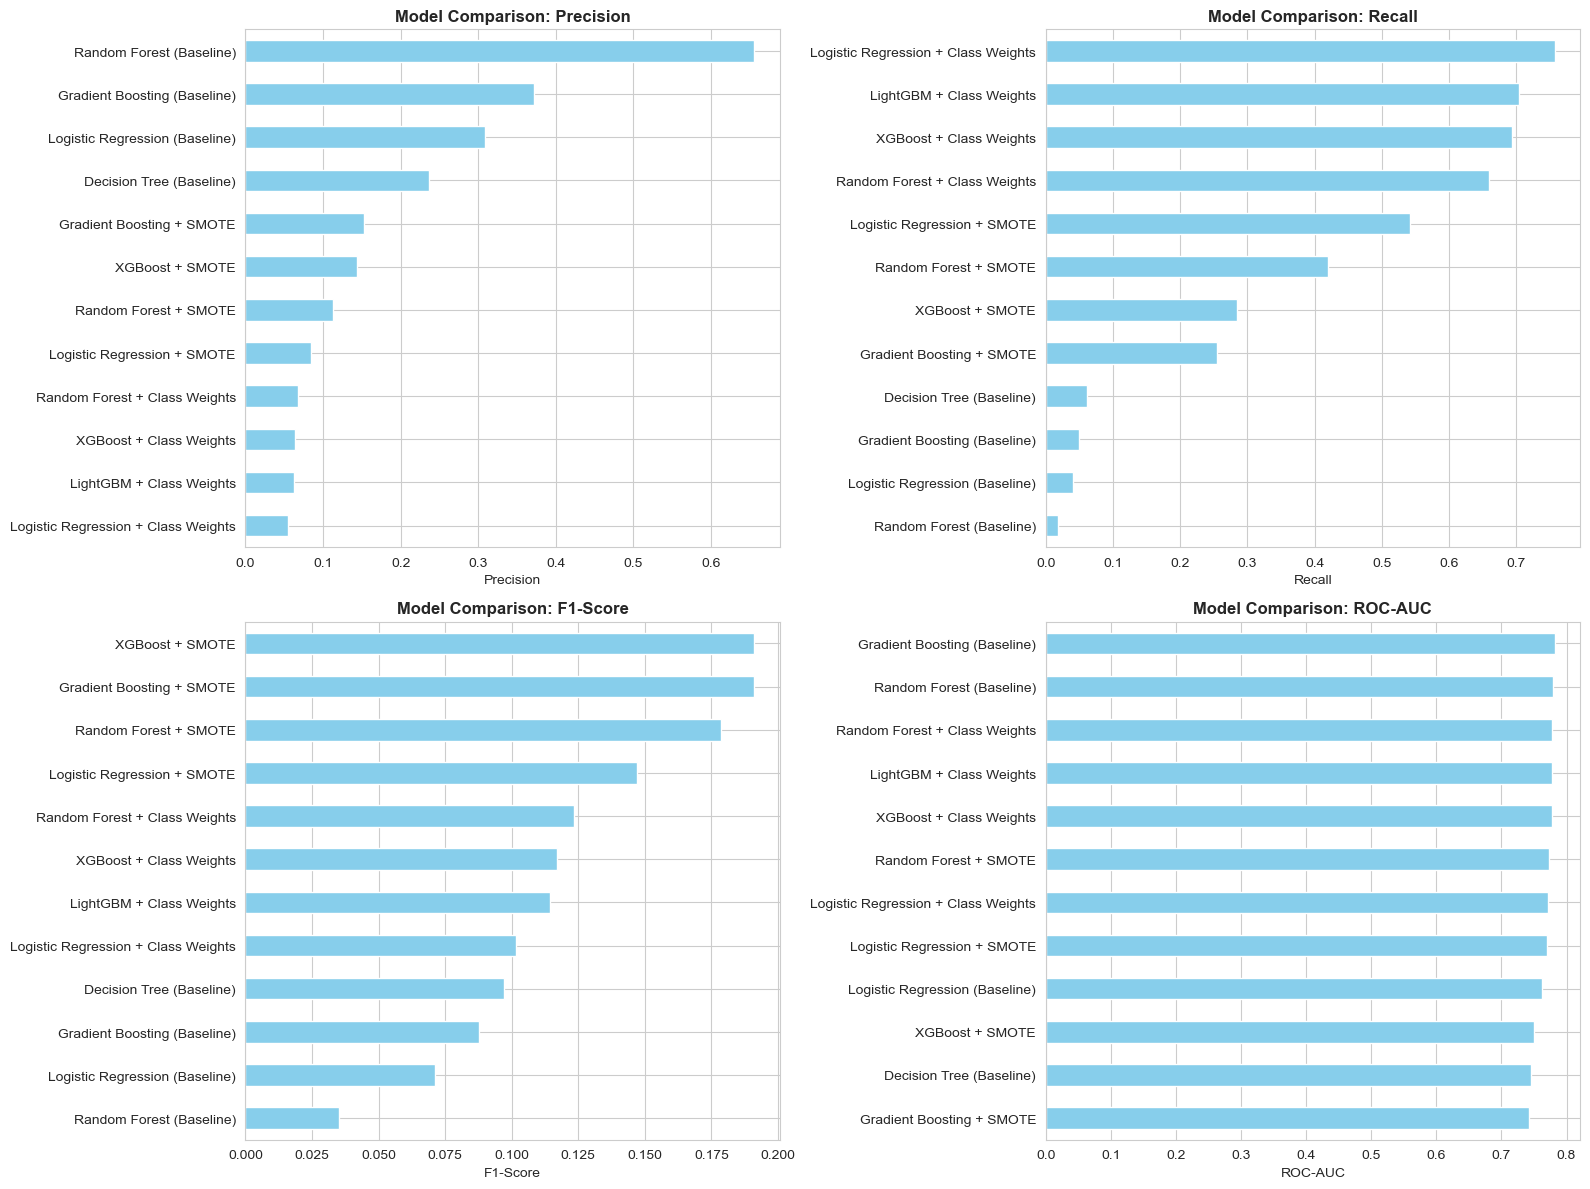

Best model by F1-Score: XGBoost + SMOTE
F1-Score: 0.1911
ROC-AUC: 0.7497
Recall: 0.2851
Precision: 0.1437


In [61]:
all_results = baseline_results + smote_results + class_weight_results + boosting_model_results
all_results_df = pd.DataFrame(all_results)
all_results_df_sorted = all_results_df.sort_values('F1-Score', ascending=False)

print('All Models Ranked by F1-Score:')
display(all_results_df_sorted)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['Precision', 'Recall', 'F1-Score', 'ROC-AUC']
for i, metric in enumerate(metrics):
    ax = axes[i // 2, i % 2]
    data = all_results_df_sorted.sort_values(metric, ascending=True)
    data.plot(x='Model', y=metric, kind='barh', ax=ax, color='skyblue', legend=False)
    ax.set_title(f'Model Comparison: {metric}', fontsize=12, fontweight='bold')
    ax.set_xlabel(metric)
    ax.set_ylabel('')

plt.tight_layout()
plt.savefig('images/models/model_comparison.png', dpi=300, bbox_inches='tight')
print('Saved: images/models/model_comparison.png')
plt.show()

print(f"Best model by F1-Score: {all_results_df_sorted.iloc[0]['Model']}")
print(f"F1-Score: {all_results_df_sorted.iloc[0]['F1-Score']:.4f}")
print(f"ROC-AUC: {all_results_df_sorted.iloc[0]['ROC-AUC']:.4f}")
print(f"Recall: {all_results_df_sorted.iloc[0]['Recall']:.4f}")
print(f"Precision: {all_results_df_sorted.iloc[0]['Precision']:.4f}")

Step 9: Hyperparameter Tuning

Top 3 Models Selected for Tuning:
                       Model  F1-Score    Recall  Precision   ROC-AUC
10           XGBoost + SMOTE  0.191110  0.285081   0.143732  0.749691
5      Random Forest + SMOTE  0.178436  0.419328   0.113331  0.773361
11  LightGBM + Class Weights  0.114214  0.703249   0.062154  0.778066
TUNING: XGBoost + SMOTE
Base Model: XGBoost
Current F1-Score: 0.1911
Training 25 iterations with 3-fold CV...
Fitting 3 folds for each of 25 candidates, totalling 75 fits
TUNING COMPLETE
Best CV F1-Score: 0.9597
Training Time: 66.3s
Best Parameters:
subsample: 0.8
n_estimators: 300
min_child_weight: 1
max_depth: 7
learning_rate: 0.15
gamma: 0.1
colsample_bytree: 0.9

XGBOOST (TUNED) RESULTS:
  Accuracy:    0.9671
  Precision:   0.1644
  Recall:      0.0729
  F1-Score:    0.1010
  ROC-AUC:     0.6823
  PR-AUC:      0.0792
  Specificity: 0.9904

  Confusion Matrix:
    TP:    1,068  FP:    5,429
    FN:   13,584
  Time: 66.33s

comparing XGBoost + SMOTE to XGBoost + SMOTE
Before:

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC,PR-AUC,Specificity,True Positives,False Positives,False Negatives,Training Time (s)
10,XGBoost + SMOTE,0.938825,0.143732,0.285081,0.191110,0.749691,0.119810,0.955828,4177,24884,10475,0.851603
6,Gradient Boosting + SMOTE,0.945110,0.152374,0.255392,0.190870,0.741899,0.116588,0.963049,3742,20816,10910,471.934834
5,Random Forest + SMOTE,0.902115,0.113331,0.419328,0.178436,0.773361,0.136436,0.914672,6144,48069,8508,8.836234
4,Logistic Regression + SMOTE,0.840700,0.085055,0.541564,0.147019,0.770344,0.107547,0.848480,7935,85358,6717,4.108692
14,LightGBM (Tuned),0.797355,0.071739,0.585790,0.127824,0.745768,0.133416,0.802858,8583,111059,6069,55.704046
8,Random Forest + Class Weights,0.762747,0.068161,0.659705,0.123556,0.778206,0.132875,0.765428,9666,132145,4986,4.440466
9,XGBoost + Class Weights,0.734600,0.063834,0.692943,0.116899,0.777215,0.145153,0.735684,10153,148901,4499,0.659959
11,LightGBM + Class Weights,0.723484,0.062154,0.703249,0.114214,0.778066,0.146721,0.724011,10304,155477,4348,0.618852
13,Random Forest (Tuned),0.962320,0.134700,0.089681,0.107674,0.655773,0.070825,0.985016,1314,8441,13338,692.309521
7,Logistic Regression + Class Weights,0.661313,0.054536,0.756620,0.101738,0.771868,0.104994,0.658834,11086,192194,3566,1.665188


Saved: images/models/tuning_comparison.png


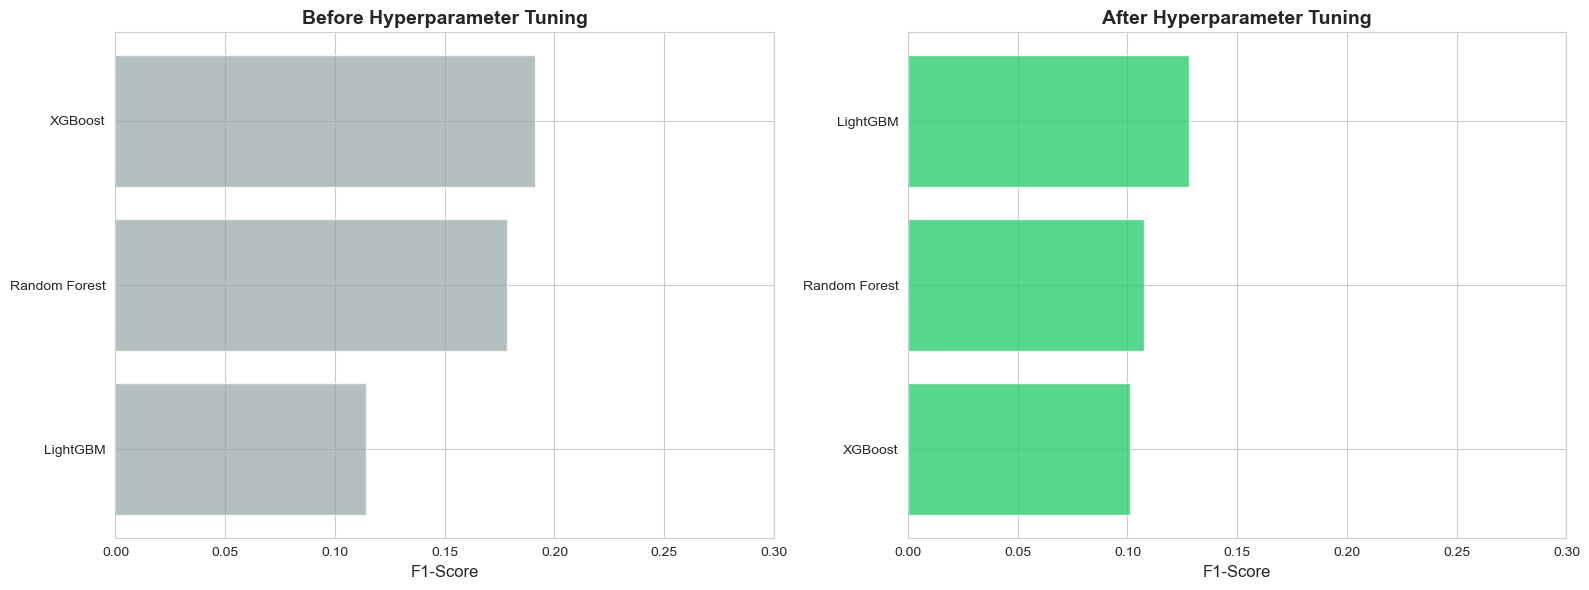

In [62]:
from sklearn.model_selection import RandomizedSearchCV 
import gc

gc.collect()

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'

models_to_tune = ['XGBoost + SMOTE', 'Random Forest + SMOTE', 'LightGBM + Class Weights']
top_3_models = all_results_df_sorted[all_results_df_sorted['Model'].isin(models_to_tune)].copy()
print("Top 3 Models Selected for Tuning:")
print(top_3_models[['Model', 'F1-Score', 'Recall', 'Precision', 'ROC-AUC']])

MODEL_CONFIGS = {
    'Random Forest': {
        'estimator': RandomForestClassifier(random_state=42, n_jobs=-1),
        'params': {
            'n_estimators': [100, 150, 200], 
            'max_depth': [15, 20, None], 
            'min_samples_split': [2, 5], 
            'min_samples_leaf': [1, 2], 
            'max_features': ['sqrt'], 
            'class_weight': ['balanced']
        },
        'n_iter': 20,
        'training_data': (X_train_smote, y_train_smote)
    },
    'XGBoost': {
        'estimator': xgb.XGBClassifier(random_state=42, eval_metric='logloss', 
                                       use_label_encoder=False, n_jobs=-1),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.05, 0.1, 0.15],
            'subsample': [0.8, 0.9],  
            'colsample_bytree': [0.8, 0.9],
            'min_child_weight': [1, 3],
            'gamma': [0, 0.1]         
        },
        'n_iter': 25,
        'training_data': (X_train_smote, y_train_smote)
    },
    'LightGBM': {
        'estimator': LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.05, 0.1, 0.15],
            'subsample': [0.8, 0.9],
            'colsample_bytree': [0.8, 0.9],
            'num_leaves': [31, 50],
            'min_child_samples': [20, 30],
            'class_weight': ['balanced']       
        },
        'n_iter': 25,
        'training_data': (X_train_scaled, y_train)
    }
}


def extract_base_model(full_name):
    for base_name in MODEL_CONFIGS.keys():
        if base_name in full_name:
            return base_name
    return None

tuned_results = []
best_models = {}

for idx, row in top_3_models.iterrows():
    model_name = row['Model']
    base_name = extract_base_model(model_name)
    
    if base_name is None:
        print(f"Skipping {model_name} - no config found")
        continue
    
    print(f"TUNING: {model_name}")
    print(f"Base Model: {base_name}")
    print(f"Current F1-Score: {row['F1-Score']:.4f}")
    
    # Get configuration
    config = MODEL_CONFIGS[base_name]
    X_train_data, y_train_data = config['training_data']
    
    # Create RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=config['estimator'],
        param_distributions=config['params'],
        n_iter=config['n_iter'],
        cv=3,
        scoring='f1',
        n_jobs=-1,
        random_state=42,
        verbose=1
    )
    
    # Fit
    print(f"Training {config['n_iter']} iterations with 3-fold CV...")
    start = time.time()
    random_search.fit(X_train_data, y_train_data)
    training_time = time.time() - start
    
    # Results
    print(f"TUNING COMPLETE")
    print(f"Best CV F1-Score: {random_search.best_score_:.4f}")
    print(f"Training Time: {training_time:.1f}s")
    print(f"Best Parameters:")
    for param, value in random_search.best_params_.items():
        print(f"{param}: {value}")
    
    # Evaluate on test set
    result = evaluate_model(name=f'{base_name} (Tuned)',
                            model=random_search.best_estimator_, 
                            X_test=X_test_scaled,
                            y_test=y_test,
                            training_time=training_time)
    tuned_results.append(result)

    best_models[base_name] = random_search.best_estimator_
    
    # Compare improvement
    improvement = result['F1-Score'] - row['F1-Score']
    print(f"comparing {model_name} to {row['Model']}")
    print(f"Before: {row['F1-Score']:.4f}")
    print(f"After:  {result['F1-Score']:.4f}")
    print(f"Gain:   {improvement:+.4f} ({improvement/row['F1-Score']*100:+.1f}%)")
    


print("Top 3 models tuning complete")

tuned_df = pd.DataFrame(tuned_results)
final_results = all_results + tuned_results
final_results_df = pd.DataFrame(final_results)
final_results_sorted = final_results_df.sort_values('F1-Score', ascending=False)

os.makedirs('results', exist_ok=True)
final_results_sorted.to_csv('results/final_all_models.csv', index=False)
display(final_results_sorted)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax = axes[0]
top_3_plot = top_3_models.copy()
# Extract base model name for display
top_3_plot['Short_Name'] = top_3_plot['Model'].str.extract(r'(XGBoost|Random Forest|LightGBM)')[0]
top_3_plot = top_3_plot.sort_values('F1-Score')
ax.barh(top_3_plot['Short_Name'], top_3_plot['F1-Score'], color='#95a5a6', alpha=0.7)
ax.set_xlabel('F1-Score', fontsize=12)
ax.set_title('Before Hyperparameter Tuning', fontsize=14, fontweight='bold')
ax.set_xlim(0, max(final_results_sorted['F1-Score'].max() * 1.1, 0.3))

ax = axes[1]
if len(tuned_results) > 0:
    tuned_plot = tuned_df.copy()
    # Extract base model name for display
    tuned_plot['Short_Name'] = tuned_plot['Model'].str.replace(' (Tuned)', '', regex=False)
    tuned_plot = tuned_plot.sort_values('F1-Score')
    ax.barh(tuned_plot['Short_Name'], tuned_plot['F1-Score'], color='#2ecc71', alpha=0.8)
    ax.set_xlabel('F1-Score', fontsize=12)
    ax.set_title('After Hyperparameter Tuning', fontsize=14, fontweight='bold')
    ax.set_xlim(0, max(final_results_sorted['F1-Score'].max() * 1.1, 0.3))

plt.tight_layout()
plt.savefig('images/models/tuning_comparison.png', dpi=300, bbox_inches='tight')
print('Saved: images/models/tuning_comparison.png')
plt.show()

Note: CV scores are inflated because they're computed on SMOTE-balanced data
Real performance should be evaluated on the imbalanced test set

Recommendation for production would be to tune on original imbalanced data using class weights, or use stratified CV that preserves class distribution.

Step 10: Model Interpretability with SHAP

In [63]:
!pip install -q shap

SHAP values computed for 31 features
Saved: images/models/shap_summary.png


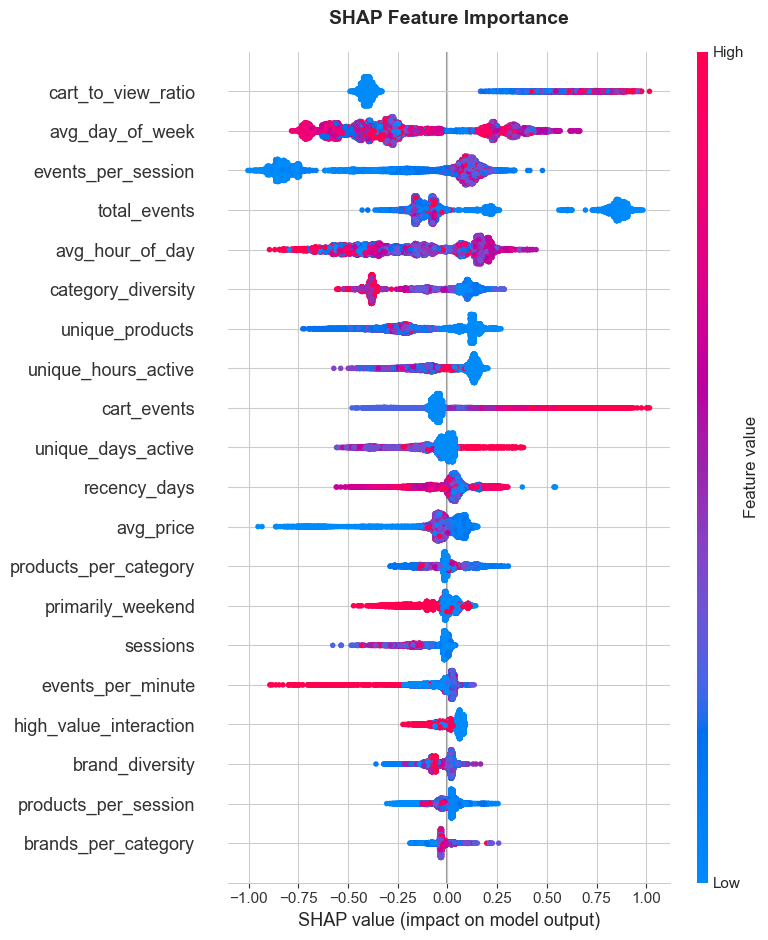

Computing permutation importance...
Saved: images/models/permutation_importance.png


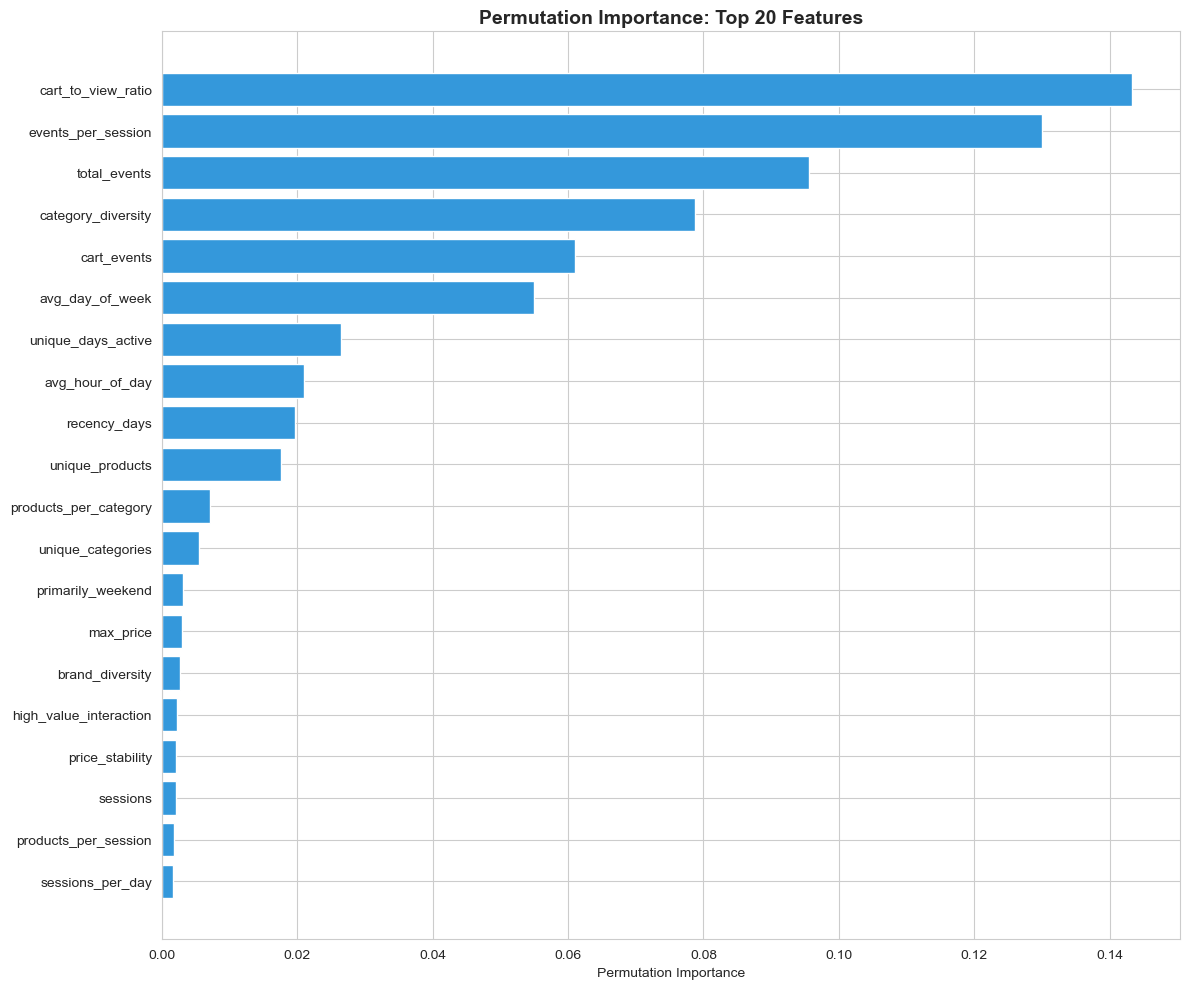

Generating partial dependence plots...
Saved: images/models/partial_dependence.png


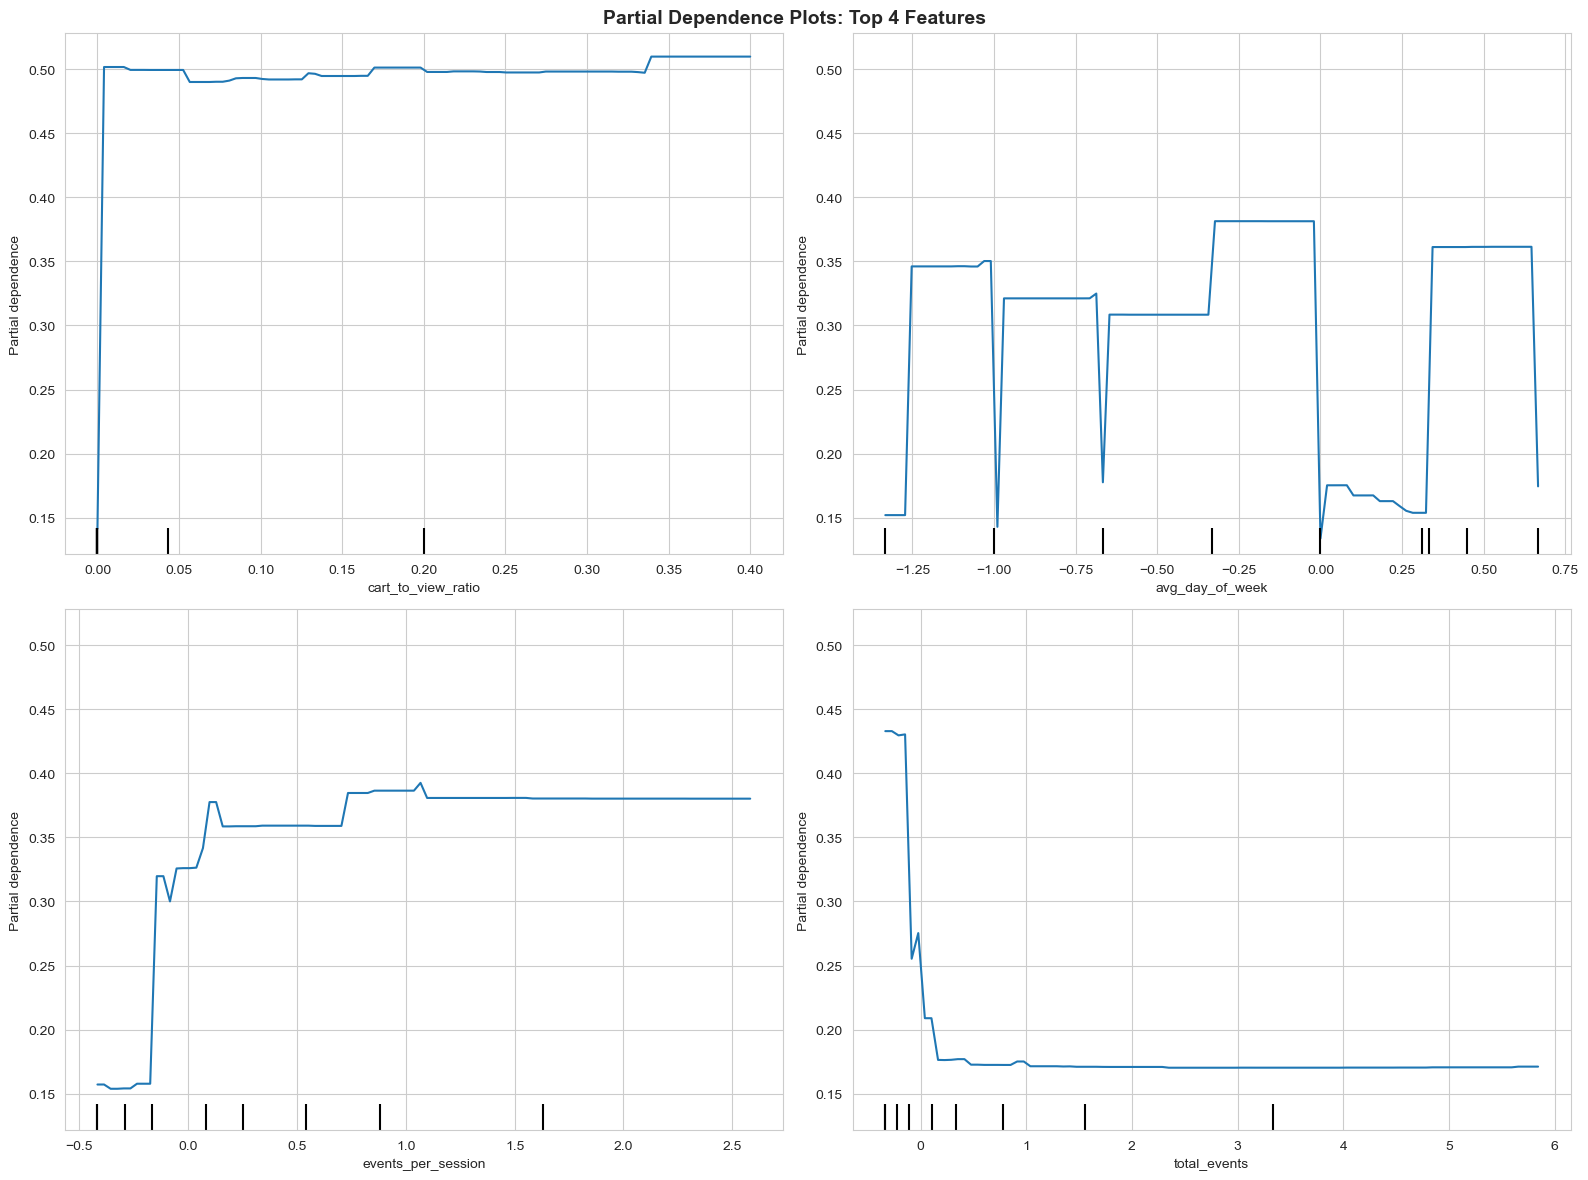

In [64]:
import shap
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

best_model = xgb_smote

sample_size = 10000
np.random.seed(42)
sample_idx = np.random.choice(X_test_scaled.shape[0], size=sample_size, replace=False)
X_test_sample = X_test_scaled.iloc[sample_idx]

# Create SHAP explainer
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_sample)

print(f"SHAP values computed for {X_test_sample.shape[1]} features")

# SHAP Summary Plot
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_test_sample, show=False, max_display=20)
plt.title("SHAP Feature Importance", fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('images/models/shap_summary.png', dpi=300, bbox_inches='tight')
print("Saved: images/models/shap_summary.png")
plt.show()
plt.close()


print("Computing permutation importance...")

perm_sample_size = 5000
perm_idx = np.random.choice(X_test_scaled.shape[0], size=perm_sample_size, replace=False)

perm_importance = permutation_importance(
    best_model,
    X_test_scaled.iloc[perm_idx],
    y_test.iloc[perm_idx],
    n_repeats=10,
    random_state=42,
    scoring='f1',
    n_jobs=-1
)

# Visualize
perm_df = pd.DataFrame({
    'feature': X_test_scaled.columns,
    'importance': perm_importance.importances_mean
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 10))
top_20 = perm_df.head(20).sort_values('importance')
plt.barh(range(len(top_20)), top_20['importance'], color='#3498db')
plt.yticks(range(len(top_20)), top_20['feature'])
plt.xlabel('Permutation Importance')
plt.title('Permutation Importance: Top 20 Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('images/models/permutation_importance.png', dpi=300, bbox_inches='tight')
print("Saved: images/models/permutation_importance.png")
plt.show()
plt.close()

print("Generating partial dependence plots...")

# Top 4 features from SHAP
shap_imp = pd.DataFrame({
    'feature': X_test_sample.columns,
    'importance': np.abs(shap_values).mean(axis=0)
}).sort_values('importance', ascending=False)

top_4_features = shap_imp.head(4)['feature'].tolist()
top_4_indices = [X_test_scaled.columns.get_loc(f) for f in top_4_features]

# Create PDP
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
PartialDependenceDisplay.from_estimator(
    best_model,
    X_test_sample,
    features=top_4_indices,
    feature_names=X_test_scaled.columns,
    ax=axes.flatten(),
    n_jobs=-1
)
plt.suptitle('Partial Dependence Plots: Top 4 Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('images/models/partial_dependence.png', dpi=300, bbox_inches='tight')
print("Saved: images/models/partial_dependence.png")
plt.show()
plt.close()